## NDVI after the Las Conchas fire in New Mexico

This notebook will be used to wrangle and plot NDVI rasters before and after the Las Conchas fire in New Mexico.

### Step 0: Restore variables

In [5]:
%store -r fire_bound_gdf ndvi_paths project

### Step 1: Import libraries

In [16]:
import earthpy
import glob
import pathlib
import hvplot.pandas
import hvplot.xarray

import pandas as pd
import geopandas as gpd
import holoviews as hv
import matplotlib as plt
import rioxarray as rxr
import xarray as xr

from datetime import datetime

### Step 2: Load the rasters into a DataArray

In [6]:
# Get a sorted list of NDVI tif file paths
ndvi_paths = sorted(list(project.project_dir.rglob('*NDVI_doy*.tif')))

# Display the first and last three files paths to check the pattern
ndvi_paths[:3], ndvi_paths[-3:]

([PosixPath('/workspaces/data/fire_boundary/las-conchas-fire-ndvi/MOD13Q1.061_2006106_to_2021273/MOD13Q1.061__250m_16_days_NDVI_doy2006113000000_aid0001.tif'),
  PosixPath('/workspaces/data/fire_boundary/las-conchas-fire-ndvi/MOD13Q1.061_2006106_to_2021273/MOD13Q1.061__250m_16_days_NDVI_doy2006129000000_aid0001.tif'),
  PosixPath('/workspaces/data/fire_boundary/las-conchas-fire-ndvi/MOD13Q1.061_2006106_to_2021273/MOD13Q1.061__250m_16_days_NDVI_doy2006145000000_aid0001.tif')],
 [PosixPath('/workspaces/data/fire_boundary/las-conchas-fire-ndvi/MOD13Q1.061_2006106_to_2021273/MOD13Q1.061__250m_16_days_NDVI_doy2021241000000_aid0001.tif'),
  PosixPath('/workspaces/data/fire_boundary/las-conchas-fire-ndvi/MOD13Q1.061_2006106_to_2021273/MOD13Q1.061__250m_16_days_NDVI_doy2021257000000_aid0001.tif'),
  PosixPath('/workspaces/data/fire_boundary/las-conchas-fire-ndvi/MOD13Q1.061_2006106_to_2021273/MOD13Q1.061__250m_16_days_NDVI_doy2021273000000_aid0001.tif')])

In [ ]:
# Load in the raster data from each .tif file

# Set the start and end of the filenames to read for the date
doy_start = -25
doy_end = -18

# Loop through each NDVI image
ndvi_das = []

for ndvi_path in ndvi_paths:
    path = ndvi_path
    path_name = ndvi_path.name

    # Get date from file name
    year_day = str(path_name[doy_start:doy_end])
    date_int = datetime.strptime(year_day, "%Y%j")
    date = date_int.strftime("%Y-%m-%d")

    # Open dataset
    da = rxr.open_rasterio(path, mask_and_scale=True).squeeze()
    # We set mask_and_scale as True so that we get NDVI values scaled
    # correctly (-1:1). We also use .squeeze() so that we drop the band 
    # variable, as there's just one band, so we can get rid of it.

    # Add date dimension and clean up metadata
    da = da.assign_coords({'date': date})
    da = da.expand_dims({'date': 1})
    da.name = 'NDVI'

    # Prepare for concatenation
    ndvi_das.append(da)

# This should match the number of paths from the download notebook: 176
len(ndvi_das)

176

In [12]:
# Combine NDVI rasters from all dates into one DataArray

ndvi_da = xr.combine_by_coords(ndvi_das, coords=['date'])

/tmp/ipykernel_3693/3636448902.py:3: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ndvi_da = xr.combine_by_coords(ndvi_das, coords=['date'])
/tmp/ipykernel_3693/3636448902.py:3: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ndvi_da = xr.combine_by_coords(ndvi_das, coords=['date'])


In [13]:
# check out the dataarray
ndvi_da.head()

<xarray.Dataset> Size: 796B
Dimensions:      (date: 5, y: 5, x: 5)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 40B -106.6 -106.6 -106.6 -106.6 -106.6
  * y            (y) float64 40B 36.07 36.07 36.07 36.07 36.07
    spatial_ref  int64 8B 0
  * date         (date) <U10 200B '2006-04-23' '2006-05-09' ... '2006-06-26'
Data variables:
    NDVI         (date, y, x) float32 500B 0.4317 0.4773 ... 0.5391 0.5391

### Step 3: Make a couple of plots to start checking out the data

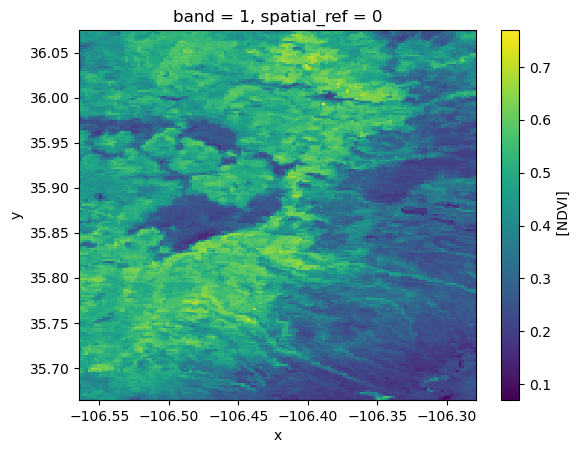

In [14]:
# Plot the first tif file

rxr.open_rasterio(ndvi_paths[0],mask_and_scale=True).squeeze().plot()

In [18]:
# Plot first and last tif files to visually compare

p_first = rxr.open_rasterio(ndvi_paths[0], mask_and_scale=True).squeeze().hvplot(x='x', y='y', cmap=plt.cm.PiYG, geo=True)
p_last = rxr.open_rasterio(ndvi_paths[153], mask_and_scale=True).squeeze().hvplot(x='x', y='y', cmap=plt.cm.PiYG, geo=True)

(p_first + p_last)

:Layout
   .Image.I  :Image   [x,y]   (value)
   .Image.II :Image   [x,y]   (value)

### Step 4: Plot difference in NDVI from before and after the fire in 2011

In [ ]:
# Get NVDI from after decision

# Convert the dates to datetime format (I used chatGPT to help figure this out)
ndvi_da['date'] = pd.to_datetime(ndvi_da['date'].values, format='%Y-%m-%d')

# Select data from 2011-2021
ndvi_aft = ndvi_da.sel(date=ndvi_da['date'].dt.year.isin([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2012]))

# Calculate the temporal mean
ndvi_mean_aft = ndvi_aft.mean(dim='date')
#ndvi_mean_aft.head()

# Get the NDVI variable

ndvi_post = ndvi_mean_aft['NDVI']
ndvi_post.head()


<xarray.DataArray 'NDVI' (y: 5, x: 5)> Size: 100B
array([[0.5813829 , 0.5813365 , 0.5813365 , 0.5787404 , 0.59436053],
       [0.58548266, 0.58548266, 0.57674354, 0.5752394 , 0.5744202 ],
       [0.5915606 , 0.5915606 , 0.5659485 , 0.559714  , 0.5812788 ],
       [0.5869928 , 0.5849332 , 0.57298374, 0.5689727 , 0.5791687 ],
       [0.57649595, 0.5761334 , 0.5740151 , 0.57949716, 0.59604424]],
      dtype=float32)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 40B -106.6 -106.6 -106.6 -106.6 -106.6
  * y            (y) float64 40B 36.07 36.07 36.07 36.07 36.07
    spatial_ref  int64 8B 0

In [23]:
# Get NDVI from before 2012 decision

# Select data from 2006-2010
ndvi_bef = ndvi_da.sel(date=ndvi_da['date'].dt.year.isin([2006, 2007, 2008, 2009, 2010]))
# Because the fire started in June 2011, we'll leave 2011 out.

# Calculate the temporal mean
ndvi_mean_bef = ndvi_bef.mean(dim='date')
#ndvi_mean_bef.head()

# Get the NDVI variable

ndvi_pre = ndvi_mean_bef['NDVI']
ndvi_pre.head()

<xarray.DataArray 'NDVI' (y: 5, x: 5)> Size: 100B
array([[0.5960618 , 0.5951728 , 0.5951728 , 0.5952873 , 0.5959055 ],
       [0.5776182 , 0.5776182 , 0.57492363, 0.58340186, 0.58628905],
       [0.56871635, 0.56871635, 0.55618906, 0.5586855 , 0.5704636 ],
       [0.56546915, 0.56408   , 0.56172734, 0.56192553, 0.577551  ],
       [0.55902   , 0.5591928 , 0.5661092 , 0.5674473 , 0.5949363 ]],
      dtype=float32)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 40B -106.6 -106.6 -106.6 -106.6 -106.6
  * y            (y) float64 40B 36.07 36.07 36.07 36.07 36.07
    spatial_ref  int64 8B 0

In [22]:
# Subtract before from after
ndvi_dif = ndvi_post - ndvi_pre
ndvi_dif.head()

<xarray.DataArray 'NDVI' (y: 5, x: 5)> Size: 100B
array([[ 0.00347769, -0.0060246 , -0.0060246 , -0.00927132,  0.00374621],
       [ 0.01793975,  0.01793975,  0.01051635,  0.00076801, -0.00104856],
       [ 0.02926707,  0.02926707,  0.01857185,  0.01144123,  0.0152204 ],
       [ 0.02957714,  0.02850991,  0.02194089,  0.01917654,  0.01458812],
       [ 0.02495307,  0.02654761,  0.01771504,  0.0205906 ,  0.01115859]],
      dtype=float32)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 40B -106.6 -106.6 -106.6 -106.6 -106.6
  * y            (y) float64 40B 36.07 36.07 36.07 36.07 36.07
    spatial_ref  int64 8B 0

In [27]:
# Plot the difference
(
    ndvi_dif.hvplot(
        x='x', y='y', cmap=plt.cm.PiYG, geo=True, 
        title='Difference in NDVI after the\nLas Conchas fire in 2011',
        xlabel='Longitude', ylabel='Latitude')
    *
    fire_bound_gdf.hvplot(geo=True, fill_color=None, line_color='black')
)

:Overlay
   .Image.I    :Image   [x,y]   (NDVI)
   .Polygons.I :Polygons   [Longitude,Latitude]

**PLOT INTERPRETATION HERE**

### Step 5: Store variables for further analysis

In [28]:
%store ndvi_da fire_bound_gdf

Stored 'ndvi_da' (Dataset)
Stored 'fire_bound_gdf' (GeoDataFrame)
